#  spectra holo at AuxTel for Scan data

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : March 29th  2022



- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

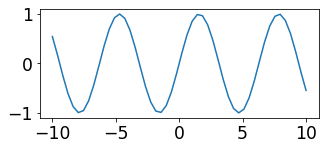

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [7]:
string_date

'2022-03-29'

In [8]:
from iminuit import Minuit
import iminuit

In [9]:
iminuit.__version__

'2.2.0'

In [10]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [11]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [12]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [13]:
from time import sleep

In [14]:
from astropy.time import Time
import astropy.units as u

# Function

In [15]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [16]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [17]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [18]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [19]:
# path index for each month
DATE="20220316"

In [20]:
version="v5.0"

# Path

In [21]:
HOSTCC=True

In [22]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/holo/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/holo/"+DATE)
    
else:
    #path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_auxtel="/Users/sylvie/DATA/AuxTelDATA2022/2022"
    #path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    #path_images=os.path.join(path_auxtel,"holo/quickLookExp_v2/"+DATE)
    path_images=os.path.join(path_auxtel,"holo/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"OutputSpectractor/holo/"+DATE)
    #path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)
    

In [23]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316'

In [24]:
! ls -l $path_output_spectractor

total 0
drwxrws--- 1 dagoret lsst 2 Mar 24 22:28 2022031600330
drwxrws--- 1 dagoret lsst 2 Mar 28 17:40 2022031600331
drwxrws--- 1 dagoret lsst 2 Mar 24 20:11 2022031600351
drwxrws--- 1 dagoret lsst 2 Mar 24 20:28 2022031600352
drwxrws--- 1 dagoret lsst 2 Mar 24 20:42 2022031600358
drwxrws--- 1 dagoret lsst 2 Mar 24 21:11 2022031600359
drwxrws--- 1 dagoret lsst 2 Mar 24 21:24 2022031600365
drwxrws--- 1 dagoret lsst 2 Mar 24 21:46 2022031600366


In [25]:

# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

# Logbook for file selection

In [26]:
# Logbook for scan data
filename_logbook='logbooks/auxtelholologbook_'+DATE+'_'+ version+'.csv'

In [27]:
df=pd.read_csv(filename_logbook,index_col=0)

In [28]:
pd.set_option('display.max_rows', None)

In [29]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2022-03-17T01:59:37.776,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600330_postisrccd.fits,330,ETA DOR,empty_1,holo4_003,1.385409,20.0,...,10.6,44.0,7.2,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2022-03-17T02:00:10.693,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600331_postisrccd.fits,331,ETA DOR,empty_1,holo4_003,1.386483,20.0,...,10.6,44.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2022-03-17T02:03:04.275,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600337_postisrccd.fits,337,ETA DOR,empty_1,holo4_003,1.392269,20.0,...,10.6,43.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2022-03-17T02:03:37.365,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600338_postisrccd.fits,338,ETA DOR,empty_1,holo4_003,1.393378,20.0,...,10.6,43.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2022-03-17T02:06:31.026,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600344_postisrccd.fits,344,ETA DOR,empty_1,holo4_003,1.399309,20.0,...,10.5,43.0,8.2,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2022-03-17T02:07:03.927,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600345_postisrccd.fits,345,ETA DOR,empty_1,holo4_003,1.400449,20.0,...,10.5,43.0,7.6,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2022-03-17T02:11:00.681,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600351_postisrccd.fits,351,HD111980,empty_1,holo4_003,1.647734,20.0,...,10.5,43.0,13.1,300.0,1700.0,NaN,NaN,,1.0,1.0
7,7,2022-03-17T02:11:33.581,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600352_postisrccd.fits,352,HD111980,empty_1,holo4_003,1.643280,20.0,...,10.5,43.0,13.1,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2022-03-17T02:14:30.261,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600358_postisrccd.fits,358,HD111980,empty_1,holo4_003,1.619945,20.0,...,10.5,43.0,12.1,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2022-03-17T02:15:03.181,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600359_postisrccd.fits,359,HD111980,empty_1,holo4_003,1.615702,20.0,...,10.5,44.0,6.9,NaN,NaN,NaN,NaN,,NaN,NaN


# Selection of input file

In [30]:
# Do not consider flag
#df_good=df[df["quality"]==1]

In [31]:
df_good=df
df_good["quality"] = 1

In [32]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2022031600330_postisrccd.fits
exposure_2022031600331_postisrccd.fits
exposure_2022031600337_postisrccd.fits
exposure_2022031600338_postisrccd.fits
exposure_2022031600344_postisrccd.fits
exposure_2022031600345_postisrccd.fits
exposure_2022031600351_postisrccd.fits
exposure_2022031600352_postisrccd.fits
exposure_2022031600358_postisrccd.fits
exposure_2022031600359_postisrccd.fits
exposure_2022031600365_postisrccd.fits
exposure_2022031600366_postisrccd.fits
exposure_2022031600372_postisrccd.fits
exposure_2022031600373_postisrccd.fits
exposure_2022031600379_postisrccd.fits
exposure_2022031600380_postisrccd.fits
exposure_2022031600386_postisrccd.fits
exposure_2022031600387_postisrccd.fits
exposure_2022031600393_postisrccd.fits
exposure_2022031600394_postisrccd.fits
exposure_2022031600400_postisrccd.fits
exposure_2022031600401_postisrccd.fits
exposure_2022031600420_postisrccd.fits
exposure_2022031600421_postisrccd.fits
exposure_2022031600427_postisrccd.fits
exposure_2022031600428_po

# Selection of Spectractor output files

In [33]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [34]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
        
        
        
        
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2022031600330', '2022031600331', '2022031600351', '2022031600352', '2022031600358', '2022031600359', '2022031600365', '2022031600366']
00330
---------------------------------------------
2022031600330  	   00330
2022031600330 is a directory
tagname= 00330
dir_plots is empty
dir_spectration is empty
00331
---------------------------------------------
2022031600331  	   00331
2022031600331 is a directory
tagname= 00331
dir_plots is not empty
dir_spectration is not empty
00351
---------------------------------------------
2022031600351  	   00351
2022031600351 is a directory
tagname= 00351
dir_plots is empty
dir_spectration is empty
00352
---------------------------------------------
2022031600352  	   00352
2022031600352 is a directory
tagname= 00352
dir_plots is not empty
dir_spectration is not empty
00358
---------------------------------------------
2022031600358  	   00358
2022031600358 is a directory
tagname= 00358
dir_plots is not empty
dir_spectration is no

In [35]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600331/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600352/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600358/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600359/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600365/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600366/basespec']


In [36]:
! ls /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600366/basespec

exposure_2022031600366_postisrccd_lines.csv
exposure_2022031600366_postisrccd_spectrogram.fits
exposure_2022031600366_postisrccd_spectrum.fits
exposure_2022031600366_postisrccd_table.csv


In [37]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [38]:
all_files_spectra[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600352/basespec/exposure_2022031600352_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600358/basespec/exposure_2022031600358_postisrccd_spectrum.fits']

In [39]:
all_files_spectrogram[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600352/basespec/exposure_2022031600352_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600358/basespec/exposure_2022031600358_postisrccd_spectrogram.fits']

In [40]:
all_files_lines[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600352/basespec/exposure_2022031600352_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600358/basespec/exposure_2022031600358_postisrccd_lines.csv']

In [41]:
all_files_table[:3] 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600352/basespec/exposure_2022031600352_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600358/basespec/exposure_2022031600358_postisrccd_table.csv']

# Selection of good spectra

In [42]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [43]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

0 ) exposure_2022031600331_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_spectrum.fits


/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      ...  Z_VALUE  SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1
1 ) exposure_2022031600352_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600352/basespec/exposure_2022031600352_postisrccd_spectrum.fits
target_name = HD111980, Selected object name for Simbad : HD111980
 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD 111980 12 53 15.0529 -18 31 20.013 ... 0.0005170                1


KeyError: "Keyword 'HA' not found."

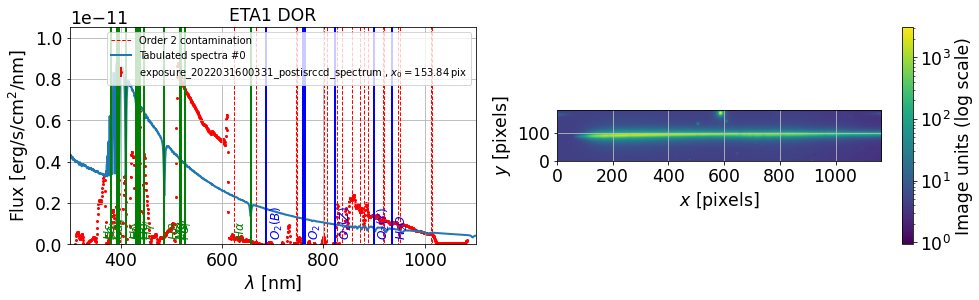

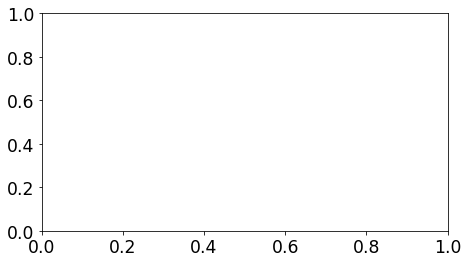

In [44]:
parameters.DISPLAY=True

infos = []
all_lambdas=[]
all_data=[]
all_num=[]

idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename = os.path.basename(fullfilename)
    print(idx,")",filename," ",fullfilename)
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    idx+=1
    

In [ ]:
fig=plt.figure(figsize=(18,16))
ax=fig.add_subplot(1,1,1)

idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename= os.path.basename(fullfilename)
         
    #s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    label=all_num[idx]
    
    
    
    delta=idx*1.0e-13
    #delta=0
    
    if label not in ["000284","000276","000289","000291"] :
        ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
        plt.text(250.,all_data[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
    
    idx+=1
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("Flux (erg/cm^2/s/nm)")
ax.set_xlim(250.,1100)
ax.grid()
ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
ax.set_title("Hologram, spectrum of HD160617 : Narrow + Wide scan of night 2021-07-07")
plt.show()
    

# Narrow scan dataset

In [ ]:
idx=0
all_num_nr = []
all_lambdas_nr = []
all_data_nr = []

for fullfilename in all_good_spectra_spectrum_files:
    
    
    if all_num[idx] >= '000317':
        all_num_nr.append(all_num[idx])
        all_lambdas_nr.append(all_lambdas[idx]) 
        all_data_nr.append(all_data[idx])
        
    idx+=1
        
    

In [ ]:
def PlotSpectra(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum of HD160617 : Narrow  scan of night 2021-07-07", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(14,8)):
    """
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
        
    
    

In [ ]:
PlotSpectra(all_lambdas_nr,all_data_nr,all_num_nr)

In [ ]:
def PlotSpectraBoth(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum of HD160617 : Narrow  scan of night 2021-07-07", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(12,12)):
    """
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, 1,height_ratios=[1, 3] ,figure=fig)
    
    #ax=fig.add_subplot(2,1,1)
    ax=fig.add_subplot(gs[0,0])
    
    idx=0
    delta=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            
        
    #ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("superimposed spectra")
    
    #ax=fig.add_subplot(2,1,2)
    ax=fig.add_subplot(gs[1,0])
    
    
    idx=0
    for idx in range(NN):
        
        delta=idx*0.5e-13
        
        label=all_tag[idx]
        
        if delta ==0:
            
            ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        elif delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("shifted spectra")
    
    
    plt.suptitle(thetitle,y=0.95,fontsize=20,fontweight="bold")
    #plt.tight_layout()
    plt.show()
        
    
    

In [ ]:
PlotSpectraBoth(all_lambdas_nr,all_data_nr,all_num_nr)

In [ ]:
idx=0
for num in all_num:
    if num == "000335":
        print(idx," ",num)
        idx0=idx
    idx+=1
idx0

In [ ]:
idx=0
for num in all_num_nr:
    if num == "000335":
        print(idx," ",num)
        idx0=idx
    idx+=1
idx0

In [ ]:
idx_ref=15

In [ ]:
from scipy.signal import savgol_filter

In [ ]:
wl=np.arange(380,1000)

In [ ]:
all_lambdas[idx0]

In [ ]:
ref=np.interp(wl, all_lambdas[idx_ref],all_data[idx_ref])

In [ ]:
yhat = savgol_filter(ref, 11, 3) # window size 51, polynomial order 3

In [ ]:
plt.plot(wl,ref,'b-')
plt.plot(wl,yhat,'r-')

In [ ]:
def PlotFilteredRatio(all_wl,all_spec,all_tag,idx_ref,window=11, 
                thetitle="Hologram, spectrum of HD160617 : Spectrum ratio Narrow  scan of night 2021-07-07", 
                thexlabel="$\\lambda$ (nm)",theylabel="spectrum ratio",figsize=(14,8)):
    """
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    wl=np.arange(380,1000)
   
    # filter    
    ref_filt = savgol_filter(all_spec[idx_ref], window, 3) # window size 11, polynomial order 3
    # interpolate
    ref_int= np.interp(wl, all_wl[idx_ref],ref_filt)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        
        spec_filt = savgol_filter(all_spec[idx], window, 3) # window size 11, polynomial order 3
        spec_int = np.interp(wl, all_wl[idx],spec_filt)
        
        ratiof = spec_int/ref_int
        
        ax.plot(wl,ratiof,label=label,color=all_colors[idx])
       
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(380.,1000)
    ax.set_ylim(0.9,1.1)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
    

In [ ]:
def PlotSpectraBothPlusRatio(all_wl,all_spec,all_tag, idx_ref,window=51,delta=0,
                             thetitle="Hologram, spectrum of HD160617 : Narrow  scan of night 2021-07-07",
                             thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(12,12)):
    """
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(3, 1,height_ratios=[1, 3,1] ,figure=fig)
    
    #ax=fig.add_subplot(2,1,1)
    ax=fig.add_subplot(gs[0,0])
    
    idx=0
    delta=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            
        
    #ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("superimposed spectra")
    
    #ax=fig.add_subplot(2,1,2)
    ax=fig.add_subplot(gs[1,0])
    
    
    idx=0
    for idx in range(NN):
        
        delta=idx*0.5e-13
        
        label=all_tag[idx]
        
        if delta ==0:
            
            ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        elif delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        
    #ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("shifted spectra")
    
    
    # plot 3
    
    wl=np.arange(380,1000)
   
    # filter    
    ref_filt = savgol_filter(all_spec[idx_ref], window, 3) # window size 11, polynomial order 3
    # interpolate
    ref_int= np.interp(wl, all_wl[idx_ref],ref_filt)
    
    
   
    ax=ax=fig.add_subplot(gs[2,0])
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        
        spec_filt = savgol_filter(all_spec[idx], window, 3) # window size 11, polynomial order 3
        spec_int = np.interp(wl, all_wl[idx],spec_filt)
        
        ratiof = spec_int/ref_int
        
        ax.plot(wl,ratiof,label=label,color=all_colors[idx])
    
    
    #ax.axhline(y=1.05,linewidth=20, color='k',xmin=wl[0], xmax=wl[-1],visible=True)
    #ax.axhline(y=0.95,linewidth=20, color='k',xmin=wl[0], xmax=wl[-1],visible=True)
    
    percent=5.0
    #ax.hlines(y=1+percent/100., xmin=wl[0], xmax=wl[-1], linewidth=1, linestyles='dashed',color='k')
    #ax.hlines(y=1-percent/100., xmin=wl[0], xmax=wl[-1], linewidth=1, linestyles='dashed',color='k')
    
    ax.hlines(y=1+percent/100., xmin=250., xmax=1100., linewidth=1, linestyles='dashed',color='k')
    ax.hlines(y=1-percent/100., xmin=250., xmax=1100., linewidth=1, linestyles='dashed',color='k')
    ax.hlines(y=1, xmin=250., xmax=1100., linewidth=1,color='k')
    
    
    ax.set_xlabel(thexlabel)
    ax.set_ylabel("ratio")
    ax.set_xlim(250.,1100)
    ax.set_ylim(0.9,1.1)
    ax.grid()
    
    ax.add_patch(Rectangle((250., 0.9), wl[0]-250., 0.2,
             #edgecolor = 'grey',
             facecolor = 'grey',
             fill=True,
             lw=5,alpha=0.5))
    
    ax.add_patch(Rectangle((wl[-1], 0.9),1100-wl[-1], 0.2,
             #edgecolor = 'grey',
             facecolor = 'grey',
             fill=True,
             lw=5,alpha=0.5))
    
    
    plt.suptitle(thetitle,y=0.95,fontsize=20,fontweight="bold")
    #plt.tight_layout()
    plt.savefig("PlotSpectraBothPlusRatio.png")
    plt.show()
        
    
    

In [ ]:
refnum=all_num_nr[idx_ref]
thetitle=f"Hologram, target HD160617 : spectrum ratio , narrow scan , night 2021-07-07, ref {refnum}"

In [ ]:
PlotFilteredRatio(all_lambdas_nr,all_data_nr,all_num_nr,idx_ref,window=51,thetitle=thetitle)

In [ ]:
#thetitle=f"Hologram, target HD160617 : narrow scan , night 2021-07-07, ref spec =  {refnum}"
thetitle=f"Hologram, target HD160617 : narrow scan , night 2021-07-07"
PlotSpectraBothPlusRatio(all_lambdas_nr,all_data_nr,all_num_nr,idx_ref,window=51,thetitle=thetitle)

### Select a ring around the reference

In [ ]:
all_num_nr=np.array(all_num_nr)

In [ ]:
ring_num = np.array(['000335','000328','000329','000334','000336','000341','000342','000343'])
ring_num

In [ ]:
indexes_ring=[ np.where(all_num_nr==idx)[0][0] for idx in  ring_num]

In [ ]:
all_lambdas_ring=[all_lambdas_nr[idx] for idx in indexes_ring]
all_data_ring =  [all_data_nr[idx] for idx in indexes_ring]
all_num_ring = [all_num_nr[idx] for idx in indexes_ring]

In [ ]:
idx_ref=0
refnum=all_num_ring[idx_ref]
thetitle=f"Hologram, target HD160617 : central ring , night 2021-07-07, ref {refnum}"

In [ ]:
PlotFilteredRatio(all_lambdas_ring,all_data_ring,all_num_ring,idx_ref,window=51,thetitle=thetitle)

In [ ]:
infos[0]

In [ ]:
infos[-1]

# Some reconstructions values in header

In [ ]:
NN=len(all_good_spectra_spectrum_files)

all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)


for idx in range(NN):
    
    fullfilename=all_good_spectra_spectrum_files[idx]
    
    filename= os.path.basename(fullfilename)
    hdul=fits.open(fullfilename)
    header=hdul[0].header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    rebin=header["REBIN"]
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    chi2_fit=header["CHI2_FIT"]
    a2_fit=header["A2_FIT"]
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    

In [ ]:
fig=plt.figure(figsize=(18,25))

# rebin
ax=fig.add_subplot(10,1,1)
ax.plot(all_tagnumber,all_rebin,"bo",label="rebin")
ax.legend()
ax.grid()
ax.set_title("rebin")

#targetx
ax=fig.add_subplot(10,1,2)
ax.plot(all_tagnumber,all_targetx,"bo",label="targetx")
ax.legend()
ax.grid()
ax.set_title("targetx")



#targety
ax=fig.add_subplot(10,1,3)
ax.plot(all_tagnumber,all_targety,"bo",label="targety")
ax.legend()
ax.grid()
ax.set_title("targety")



#rotangle
ax=fig.add_subplot(10,1,4)
ax.plot(all_tagnumber,all_rotangle,"bo",label="rotangle")
ax.legend()
ax.grid()
ax.set_title("rotangle")

#d2ccd
ax=fig.add_subplot(10,1,5)
ax.plot(all_tagnumber,all_d2ccd,"bo",label="d2ccd")
ax.legend()
ax.grid()
ax.set_title("d2ccd")


#pixshift
ax=fig.add_subplot(10,1,6)
ax.plot(all_tagnumber,all_pixshift,"bo",label="pixshift")
ax.legend()
ax.grid()
ax.set_title("pixshift")


#chi2_fit
ax=fig.add_subplot(10,1,7)
ax.plot(all_tagnumber,all_chi2_fit,"bo",label="chi2_fit")
ax.legend()
ax.grid()
ax.set_title("chi2_fit")

#a2_fit
ax=fig.add_subplot(10,1,8)
ax.plot(all_tagnumber,all_a2_fit,"bo",label="a2_fit")
ax.legend()
ax.grid()
ax.set_title("a2_fit")


#all_lbda_ref
ax=fig.add_subplot(10,1,9)
ax.plot(all_tagnumber,all_lbda_ref,"bo",label="lbda_ref")
ax.legend()
ax.grid()
ax.set_title("lbda_ref")


plt.tight_layout()

# Find bad reconstructions

In [ ]:
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax.hist(all_d2ccd,bins=40,facecolor="blue")
ax.set_xlabel("d2ccd (mm)")

ax=fig.add_subplot(1,2,1)

arg_bad=np.where(abs(all_d2ccd-180)>0.5)[0]
list_bad=all_tagnumber[arg_bad]
ax.set_title("Distance holo-CCD")

ax=fig.add_subplot(1,2,2)
# indexes of elements in tag that are in list_bad
arg_badindexes=np.where(np.in1d(all_tagnumber, list_bad))
# indexes of elements in tag that are NOT in list_bad
arg_goodindexes=np.where(np.in1d(all_tagnumber,np.setdiff1d(all_tagnumber, list_bad)))

DCCD_avr = np.mean(all_d2ccd[arg_goodindexes])
DCCD_std = np.std(all_d2ccd[arg_goodindexes])

textstr = '\n'.join((
    r'$\mu=%.2f$ mm' % (DCCD_avr, ),
    r'$\sigma=%.2f$ mm' % (DCCD_std, )))


props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#props = dict(boxstyle='round')

# place a text box in upper left in axes coords
ax.text(0.60, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)





ax.hist(all_d2ccd,bins=40,facecolor="blue")
ax.hist(all_d2ccd[arg_badindexes],bins=40,facecolor="red")
ax.set_xlabel("d2ccd (mm)")
ax.set_title("Distance holo-CCD")




## Good value for DCCD

In [ ]:
np.mean(all_d2ccd[arg_goodindexes])

In [ ]:
np.std(all_d2ccd[arg_goodindexes])

In [ ]:
def plotbad(arg_badindexes):
    
    fig=plt.figure(figsize=(18,25))

    # rebin
    ax=fig.add_subplot(10,1,1)
    ax.plot(all_tagnumber,all_rebin,"bo",label="rebin")
    ax.plot(all_tagnumber[arg_badindexes],all_rebin[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("rebin")

    #targetx
    ax=fig.add_subplot(10,1,2)
    ax.plot(all_tagnumber,all_targetx,"bo",label="targetx")
    ax.plot(all_tagnumber[arg_badindexes],all_targetx[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("targetx")



    #targety
    ax=fig.add_subplot(10,1,3)
    ax.plot(all_tagnumber,all_targety,"bo",label="targety")
    ax.plot(all_tagnumber[arg_badindexes],all_targety[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("targety")



    #rotangle
    ax=fig.add_subplot(10,1,4)
    ax.plot(all_tagnumber,all_rotangle,"bo",label="rotangle")
    ax.plot(all_tagnumber[arg_badindexes],all_rotangle[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("rotangle")

    #d2ccd
    ax=fig.add_subplot(10,1,5)
    ax.plot(all_tagnumber,all_d2ccd,"bo",label="d2ccd")
    ax.plot(all_tagnumber[arg_badindexes],all_d2ccd[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("d2ccd")


    #pixshift
    ax=fig.add_subplot(10,1,6)
    ax.plot(all_tagnumber,all_pixshift,"bo",label="pixshift")
    ax.plot(all_tagnumber[arg_badindexes],all_pixshift[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("pixshift")


    #chi2_fit
    ax=fig.add_subplot(10,1,7)
    ax.plot(all_tagnumber,all_chi2_fit,"bo",label="chi2_fit")
    ax.plot(all_tagnumber[arg_badindexes],all_chi2_fit[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("chi2_fit")

    #a2_fit
    ax=fig.add_subplot(10,1,8)
    ax.plot(all_tagnumber,all_a2_fit,"bo",label="a2_fit")
    ax.plot(all_tagnumber[arg_badindexes],all_a2_fit[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("a2_fit")


    #all_lbda_ref
    ax=fig.add_subplot(10,1,9)
    ax.plot(all_tagnumber,all_lbda_ref,"bo",label="lbda_ref")
    ax.plot(all_tagnumber[arg_badindexes],all_lbda_ref[arg_badindexes],"ro",label="bad")
    ax.legend()
    ax.grid()
    ax.set_title("lbda_ref")


    plt.tight_layout()
    

In [ ]:
plotbad(arg_badindexes)

# List of bad Spectra

In [ ]:
print("list of bad Spectra : ",list_bad)

# Selection of the spectrum


This is an example to show how to access to information on reconstructed spectra

In [ ]:
IDXSEL=33

In [ ]:
all_good_spectra_spectrum_files[IDXSEL]

In [ ]:
fullfilename_SEL=all_good_spectra_spectrum_files[IDXSEL]
fullfilename_spectrogram_SEL=fullfilename_SEL.replace("_spectrum","_spectrogram")
fullfilename_lines_SEL=fullfilename_SEL.replace("_spectrum.fits","_lines.csv")
fullfilename_table_SEL=fullfilename_SEL.replace("_spectrum.fits","_table.csv")

In [ ]:
filename_SEL = os.path.basename(fullfilename_SEL)
filename_spectrogram_SEL = os.path.basename(fullfilename_spectrogram_SEL)
filename_lines_SEL = os.path.basename(fullfilename_lines_SEL)
filename_table_SEL = os.path.basename(fullfilename_table_SEL)

## Spectrum

In [ ]:
spectrum_hdu=fits.open(fullfilename_SEL)

In [ ]:
spectrum_hdu.info()

In [ ]:
spectrum_hdu[0].header

In [ ]:
fig=plt.figure(figsize=(16,10))

# Spectrum
ax=fig.add_subplot(4,1,1)
x=spectrum_hdu[0].data[0,:]
y=spectrum_hdu[0].data[1,:]
yerr=spectrum_hdu[0].data[1,:]
ax.errorbar(x, y, yerr=yerr, fmt='o',markersize=0.5,color="r",ecolor="gray")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_title("spectrum")
ax.grid()

# Covariance

from astropy.visualization import (MinMaxInterval, SqrtStretch,ImageNormalize,LogStretch)

ax=fig.add_subplot(4,1,2)
img=spectrum_hdu[1].data

# Create an ImageNormalize object
norm = ImageNormalize(img, interval=MinMaxInterval(),stretch=LogStretch())


#ax.imshow(img,origin="lower",norm=LogNorm())
ax.imshow(img,origin="lower",norm=norm)
ax.grid()
ax.set_title("Covariance")


# Order 2
ax=fig.add_subplot(4,1,3)
x=spectrum_hdu[2].data[0,:]
y=spectrum_hdu[2].data[1,:]
yerr=spectrum_hdu[2].data[1,:]
ax.errorbar(x, y, yerr=yerr, fmt='o',markersize=0.5,color="r",ecolor="gray")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_title("Order 2")
ax.grid()

# ORDER0  
ax=fig.add_subplot(4,1,4)
img=spectrum_hdu[3].data
ax.imshow(img,origin="lower",norm=LogNorm())
ax.grid()
ax.set_title("Order 0")

plt.tight_layout()

In [ ]:
fullfilename_spectrogram_SEL

## Spectrogram

In [ ]:
spectrogram_hdu=fits.open(fullfilename_spectrogram_SEL)

In [ ]:
spectrogram_hdu.info()

## header of spectrogram

In [ ]:
header=spectrogram_hdu[0].header
header

In [ ]:
spectrogram_image= spectrogram_hdu[0].data

## Lines

In [ ]:
df_lines=pd.read_csv(fullfilename_lines_SEL,index_col=0)

In [ ]:
df_lines

In [ ]:
df_lines.columns

In [ ]:
df_lines.index[0]

In [ ]:
idx=0
all_lines = []
for index, row in df_lines.iterrows():
    print(df_lines.index[idx], row['Tabulated'])
    line = Line(row['Tabulated'], label=df_lines.index[idx], atmospheric=False , emission=True, label_pos=[0, 0.8])
    if row['SNR']>5:
        all_lines.append(line)
    idx+=1

In [ ]:
lines_collection=Lines(all_lines)

In [ ]:
df_table=pd.read_csv(fullfilename_table_SEL)

In [ ]:
df_table.head()

In [ ]:
fig = plt.figure(figsize=(18,10))
ax=fig.add_subplot(2,1,1)
ax.plot(s.lambdas,s.data,"r-")
thetitle=str(IDXSEL)+") "+ filename_SEL
ax.set_title(thetitle)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux")
ax.grid()
ax.set_ylim(0,2e-12)
lines_collection.plot_atomic_lines(ax, color_atomic='g', color_atmospheric='b', fontsize=20, force=True)
ax=fig.add_subplot(2,1,2)
ax.imshow(spectrogram_image,origin="lower",norm=LogNorm())
ax.grid()
ax.set_xlabel("pixel")
plt.show()

## Tables

In [ ]:
df_table=pd.read_csv(fullfilename_table_SEL,index_col=0)

In [ ]:
df_table.head()

In [ ]:
df_table.tail()

In [ ]:
# df_table.index.get_level_values

In [ ]:
# df_table.index.get_level_values

In [ ]:
df_table['wl'] = df_table.index

In [ ]:
#df_table.reset_index()

In [ ]:
df_table.head()

In [ ]:
df_table.columns

In [ ]:
fig=plt.figure(figsize=(16,30))

idx=0
column_names=df_table.columns
NN=len(column_names)

# Dx
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel(column_names[idx-1])
ax.grid()
# Dy
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# Dy_disp_axis
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# flux_sum
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# flux_integral
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

#flux_err
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# fwhm

idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# Dy_fwhm_sup
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# Dy_fwhm_inf
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# amplitude 
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()


# x_c
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# y_c
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# gamma
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()


# alpha 
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# saturation
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()




# Atmospheric conditions

In [ ]:
df_infos=pd.DataFrame(infos,columns=["idx","date_obs","airmass","temperature","pressure","humidity"])

In [ ]:
df_infos.set_index('idx',inplace=True)

In [ ]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [ ]:
all_reftime=np.array(all_reftime)

In [ ]:
df_infos["reftime"]=all_reftime

In [ ]:
df_infos["eqw_h2o"] = np.nan
df_infos["eqw_o2"] = np.nan
df_infos["eqw_o2_spec"] = np.nan

In [ ]:
df_infos

# STOP HERE

In [ ]:
assert False

# Selection of spectra and equivalent width calculation

In [ ]:
from astropy import units as u
from astropy.visualization import quantity_support

quantity_support()  # for getting units on the axes below  

In [ ]:
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum,fit_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from astropy.modeling import models
from specutils.manipulation import extract_region

In [ ]:
IDXSEL=0
filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
filename_lines_SEL=filename_SEL.replace("_spectrum.fits","_lines.csv")
filename_table_SEL=filename_SEL.replace("_spectrum.fits","_table.csv")
fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
fullfilename_lines_SEL = fullfilename_SEL.replace("_spectrum.fits","_lines.csv")
fullfilename_table_SEL = fullfilename_SEL.replace("_spectrum.fits","_table.csv")

In [ ]:
fullfilename_table_SEL

In [ ]:
thetitle=str(IDXSEL)+") "+filename_SEL

In [ ]:
thetitle

In [ ]:
fullfilename_SEL

## Load spectrum and Spectrogram

In [ ]:
s=Spectrum(fullfilename_SEL, config=config)
s.load_spectrogram(fullfilename_spectrogram_SEL) 

In [ ]:
df_lines=pd.read_csv(fullfilename_lines_SEL,index_col=0)

In [ ]:
df_lines

In [ ]:
lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)

In [ ]:
s.lines = lines

In [ ]:
lambdas = np.arange(300,1000,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)

In [ ]:
# global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)

In [ ]:
fig = plt.figure(figsize=(18,10))
plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
lines.plot_detected_lines(plt.gca())
thetitle=str(IDXSEL)+") "+ filename_SEL
plt.title(thetitle)
plt.show()

In [ ]:
# lines.print_detected_lines()

In [ ]:
alert False

## with specutils

### Convert in specutils units

In [ ]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

## Equivalent width calculation with Automatic line plot

In [ ]:
def ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True)
    
    - input :
    
    
    - output :
    
    """
            
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
    
    eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
    eqw2=equivalent_width(cont_norm_spec, regions=sub_region)  
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\AA$ ".format(eqw1.value)
        eqw_str2="$Eqw_2$ = {:2.2f} $\AA$ ".format(eqw2.value)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        
    return eqw1.value,eqw2.value     

In [ ]:
def ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline)
    
    - input :
    
    
    - output :
    
    """
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
         
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
       
    eqw10=equivalent_width(cont_norm_spec, regions=line_region).value 
    eqw20=equivalent_width(cont_norm_spec, regions=sub_region).value 
       
    # Bootstrap
    
    
    eqw1_set=np.zeros(NN)
    eqw2_set=np.zeros(NN)
    size=len(specerr.flux)
    
    # loop on trials 
    for idx in np.arange(NN):
        
        # random generator for errors
        s = np.random.normal(0, 1, size)
        
        # new flux
        newspec = Spectrum1D(spectral_axis=spec.spectral_axis, flux=spec.flux+specerr.flux*s)
              
    
        # region where one extract the spectrum
        sub_spectrum = extract_region(newspec, sub_region)
    
        # initialisaition of linear model
        g_init = models.Linear1D(slope=0,intercept=1e-12)
    
        # fit on sub-spectrum
        g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
        # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
        g2_fit = fit_continuum(newspec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
        y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
        y_continuum_fitted2 = g2_fit(newspec.spectral_axis)
    
        # normalize the spectrum
        cont_norm_spec = newspec/ y_continuum_fitted2 
    
    
        eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
        eqw2=equivalent_width(cont_norm_spec, regions=sub_region) 
        
        
        eqw1_set[idx]=eqw1.value
        eqw2_set[idx]=eqw2.value
        
     
    eqw1_std=eqw1_set.std()
    eqw2_std=eqw2_set.std()
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw10,eqw1_std)
        eqw_str2="$Eqw_2$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw20,eqw2_std)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
               
        
    return eqw10,eqw20,eqw1_set,eqw2_set     

### The original spectrum

#### O2 line

In [ ]:
wlmin=10*(O2_1.wavelength-30)*u.AA
wlmax=10*(O2_1.wavelength+30)*u.AA
wlminline=10*(O2_1.wavelength-10)*u.AA
wlmaxline=10*(O2_1.wavelength+10)*u.AA

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color="b");
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

### H2O line

In [ ]:
wlmin=10*(H2O_1.wavelength-30)*u.AA
wlmax=10*(H2O_2.wavelength+30)*u.AA
wlminline=10*(H2O_1.wavelength-12)*u.AA
wlmaxline=10*(H2O_2.wavelength+10)*u.AA

In [ ]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color='b');
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

# Loop on spectra with Spectractor

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,7):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    #wlidx=np.where(np.logical_and( s.lambdas>=WLMIN, s.lambdas<=WLMAX))[0]
    #print(wlidx)
    #wl=s.lambdas[wlidx]
    
    #specify the lines  
    lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)
    s.lines = lines
    
    global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)
    
    print(IDXSEL,") ",filename_SEL)
    thetitle=str(IDXSEL)+") "+filename_SEL
    
    fig = plt.figure(figsize=(10,5))
    plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
    lines.plot_detected_lines(plt.gca())
    plt.title(thetitle)
    plt.show()
    
    print(lines.print_detected_lines())
    print(lines.print_detected_lines()[0]["Eqwidth_data"])
    df_infos.at[IDXSEL,"eqw_o2_spec"] = lines.print_detected_lines()[0]["Eqwidth_data"]*10.
    
    

In [ ]:
print(lines.print_detected_lines())

In [ ]:
type(lines.print_detected_lines())

In [ ]:
print(lines.print_detected_lines()[0]["Eqwidth_data"])

In [ ]:
df_infos

# Loop on spectrum, compute O2 line equivalent width with specutils 

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,8):

    
    
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    
    print(IDXSEL,") ",filename_SEL)
    
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # O2 line
    wlmin=10*(O2_1.wavelength-30)*u.AA
    wlmax=10*(O2_1.wavelength+30)*u.AA
    wlminline=10*(O2_1.wavelength-10)*u.AA
    wlmaxline=10*(O2_1.wavelength+10)*u.AA
    
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    #eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw10)
    
    df_infos.at[IDXSEL,"eqw_o2"] =  eqw10

# Loop on spectrum, compute H2O line equivalent width with specutils 

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,8):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # H2O line
    
    wlmin=10*(H2O_1.wavelength-30)*u.AA
    wlmax=10*(H2O_2.wavelength+30)*u.AA
    wlminline=10*(H2O_1.wavelength-12)*u.AA
    wlmaxline=10*(H2O_2.wavelength+10)*u.AA
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    eqw1,eqw2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    #eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw1)
    
    df_infos.at[IDXSEL,"eqw_h2o"] =  eqw1

In [ ]:
df_infos

In [ ]:
df_infos.to_csv("eqw.csv")

In [ ]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['date_obs'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass")
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")

In [ ]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
df_infos.plot(ax=ax,x="date_obs", y=["eqw_o2","eqw_h2o"],color=["r","b"],marker="o");
#plt.gcf().autofmt_xdate(rotation=90) 
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax.set_yscale("log")

ax2 = ax.twinx()
df_infos.plot(ax=ax2,x="date_obs", y="airmass",color=["g"],marker="o",lw=0);
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax2.set_ylim(1,2)
ax2.xaxis.set_tick_params(rotation=90)
ax.set_title("Equivalent Widths vs date")


In [ ]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['reftime'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['reftime'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['reftime'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass",lw=0)
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")